## Load Preprocessed Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [44]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/Electronics_processed.csv', index_col=0)
df

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,review_time
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",got gps husband otr road trucker impressed shi...,5.0,Gotta have GPS!,1370131200,2013-06-02
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]",professional otr truck driver bought tnd truck...,1.0,Very Disappointed,1290643200,2010-11-25
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]",well say unit truck four day prior garmin nont...,3.0,1st impression,1283990400,2010-09-09
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]",going write long review even thought unit dese...,2.0,"Great grafics, POOR GPS",1290556800,2010-11-24
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",mine year got try route non truck route tellin...,1.0,"Major issues, only excuses for support",1317254400,2011-09-29
...,...,...,...,...,...,...,...,...,...
1689183,A34BZM6S9L7QI4,B00LGQ6HL8,"Candy Cane ""Is it just me?""","[1, 1]",burned listening hour sine wave app learned mu...,5.0,Boom -- Pop -- Pow. These deliver.,1405555200,2014-07-17
1689184,A1G650TTTHEAL5,B00LGQ6HL8,"Charles Spanky ""Zumina Reviews""","[0, 0]",people like dj style headphone earbud style he...,5.0,"Thin and light, without compromising on sound ...",1405382400,2014-07-15
1689185,A25C2M3QF9G7OQ,B00LGQ6HL8,Comdet,"[0, 0]",im big fan brainwavz actually headphone yet di...,5.0,Same form factor and durability as the S1 with...,1405555200,2014-07-17
1689186,A1E1LEVQ9VQNK,B00LGQ6HL8,J. Chambers,"[0, 0]",used thebrainwavz ear headphone outstanding au...,5.0,Superb audio quality in a very comfortable set...,1405641600,2014-07-18


Summary Statistics

In [64]:
# Statistics of non-numeric variables

# Number of unique customers
print('\nNumber of unique customers : {}'.format(len(df['reviewerID'].unique())))
      
# Number of unique products
print('\nNumber of unique products : {}'.format(len(df['asin'].unique())))
      
# Review number per unique customer
print('\nReview per customer: {}'.format((len(df)/len(df['reviewerID'].unique()))))      

# Review number per unique product 
print('\nReview per product: {}'.format((len(df)/len(df['asin'].unique()))))


Number of unique customers : 192402

Number of unique products : 63001

Review per customer: 8.77373416076756

Review per product: 26.79455881652672


## Exploratory Data Analysis

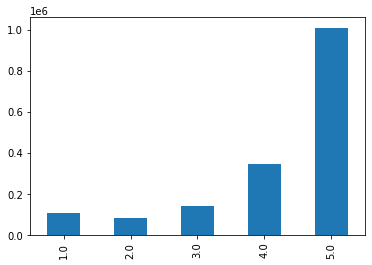

In [13]:
df['overall'].value_counts().sort_index().plot(kind="bar")

## Model Development

Split data into train and test set

In [ ]:
X = df['reviewText']
y = df['overall']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


ModuleNotFoundError: No module named 'transformers'